# Configs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients

patients = getMonitoredPatients()

In [3]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [4]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Seperate static and dynamic

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    def __init__(self, inSize):
        super(LSTMModel, self).__init__()

        self.inSize = inSize

        self.lstm = nn.LSTM(
            input_size=inSize, hidden_size=64, batch_first=True, dropout=0.5
        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(2)
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)

        return x

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=20,
    earlyStopping=5,
):
    model.to(device)

    optimScheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)

    # early stopping
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        model.train()
        trainLoss = 0

        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            loss = criterion(outputs, batchY)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            trainLoss += loss.item() * batchX.size(0)

        trainLoss /= len(trainLoader.dataset)
        trainLosses.append(trainLoss)

        # validation
        model.eval()
        valLoss = 0

        with torch.no_grad():
            for batchX, batchY in valLoader:
                batchX, batchY = batchX.to(device), batchY.to(device)

                outputs = model(batchX)
                loss = criterion(outputs, batchY)

                valLoss += loss.item() * batchX.size(0)

        valLoss /= len(valLoader.dataset)
        valLosses.append(valLoss)
        
        optimScheduler.step(valLoss, epoch)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(
            f"Epoch {epoch+1}/{epochs} Train Loss: {trainLoss:.4f} Val Loss: {valLoss:.4f}"
        )

        if patience > earlyStopping:
            break

    model.load_state_dict(bestModelState)
    return model, trainLosses, valLosses


def predTest(model, device, testLoader):
    model.eval()

    predProbas = []
    actuals = []

    with torch.no_grad():
        for batchX, batchY in testLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            probas = torch.sigmoid(outputs)
            predProbas.extend(probas.cpu().numpy())
            actuals.extend(batchY.cpu().numpy())

    return predProbas, actuals

In [7]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = LSTMModel(inSize=npTrainX.shape[2])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        _, trainLosses, valLosses = train(
            model, device, trainLoader, valLoader, criterion, optimizer, epochs=20
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6463 Val Loss: 0.6293
Epoch 2/20 Train Loss: 0.5764 Val Loss: 0.5775
Epoch 3/20 Train Loss: 0.5212 Val Loss: 0.5540
Epoch 4/20 Train Loss: 0.5025 Val Loss: 0.5466
Epoch 5/20 Train Loss: 0.4859 Val Loss: 0.5560
Epoch 6/20 Train Loss: 0.4794 Val Loss: 0.5558
Epoch 7/20 Train Loss: 0.4712 Val Loss: 0.5598
Epoch 8/20 Train Loss: 0.4543 Val Loss: 0.5504
Epoch 9/20 Train Loss: 0.4516 Val Loss: 0.5492
Epoch 10/20 Train Loss: 0.4524 Val Loss: 0.5552
Epoch 1/20 Train Loss: 0.6590 Val Loss: 0.6155


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 2/20 Train Loss: 0.5925 Val Loss: 0.5754
Epoch 3/20 Train Loss: 0.5375 Val Loss: 0.5301
Epoch 4/20 Train Loss: 0.5083 Val Loss: 0.5252
Epoch 5/20 Train Loss: 0.4977 Val Loss: 0.5174
Epoch 6/20 Train Loss: 0.4784 Val Loss: 0.5002
Epoch 7/20 Train Loss: 0.4694 Val Loss: 0.5235
Epoch 8/20 Train Loss: 0.4619 Val Loss: 0.5014
Epoch 9/20 Train Loss: 0.4500 Val Loss: 0.5463
Epoch 10/20 Train Loss: 0.4365 Val Loss: 0.5257
Epoch 11/20 Train Loss: 0.4412 Val Loss: 0.5216
Epoch 12/20 Train Loss: 0.4358 Val Loss: 0.5207
Epoch 1/20 Train Loss: 0.6568 Val Loss: 0.6209
Epoch 2/20 Train Loss: 0.6002 Val Loss: 0.5567
Epoch 3/20 Train Loss: 0.5349 Val Loss: 0.4972
Epoch 4/20 Train Loss: 0.5088 Val Loss: 0.4704
Epoch 5/20 Train Loss: 0.5077 Val Loss: 0.4549
Epoch 6/20 Train Loss: 0.4880 Val Loss: 0.4631
Epoch 7/20 Train Loss: 0.4809 Val Loss: 0.4759
Epoch 8/20 Train Loss: 0.4737 Val Loss: 0.4641
Epoch 9/20 Train Loss: 0.4677 Val Loss: 0.4628
Epoch 10/20 Train Loss: 0.4622 Val Loss: 0.4669
Epoch 11/

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6502 Val Loss: 0.6498
Epoch 2/20 Train Loss: 0.5747 Val Loss: 0.6070
Epoch 3/20 Train Loss: 0.5159 Val Loss: 0.5833
Epoch 4/20 Train Loss: 0.4773 Val Loss: 0.5765
Epoch 5/20 Train Loss: 0.4557 Val Loss: 0.5876
Epoch 6/20 Train Loss: 0.4490 Val Loss: 0.5936
Epoch 7/20 Train Loss: 0.4347 Val Loss: 0.6039
Epoch 8/20 Train Loss: 0.4307 Val Loss: 0.6042
Epoch 9/20 Train Loss: 0.4295 Val Loss: 0.5926
Epoch 10/20 Train Loss: 0.4182 Val Loss: 0.6010
Epoch 1/20 Train Loss: 0.6690 Val Loss: 0.6337
Epoch 2/20 Train Loss: 0.6049 Val Loss: 0.5882
Epoch 3/20 Train Loss: 0.5507 Val Loss: 0.5464
Epoch 4/20 Train Loss: 0.5094 Val Loss: 0.5192
Epoch 5/20 Train Loss: 0.4917 Val Loss: 0.5087
Epoch 6/20 Train Loss: 0.4847 Val Loss: 0.4993
Epoch 7/20 Train Loss: 0.4723 Val Loss: 0.4990
Epoch 8/20 Train Loss: 0.4538 Val Loss: 0.4921
Epoch 9/20 Train Loss: 0.4422 Val Loss: 0.4912
Epoch 10/20 Train Loss: 0.4341 Val Loss: 0.4902
Epoch 11/20 Train Loss: 0.4188 Val Loss: 0.4938
Epoch 12/2

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6681 Val Loss: 0.6484
Epoch 2/20 Train Loss: 0.6025 Val Loss: 0.6031
Epoch 3/20 Train Loss: 0.5426 Val Loss: 0.5557
Epoch 4/20 Train Loss: 0.5087 Val Loss: 0.5479
Epoch 5/20 Train Loss: 0.4913 Val Loss: 0.5449
Epoch 6/20 Train Loss: 0.4763 Val Loss: 0.5478
Epoch 7/20 Train Loss: 0.4664 Val Loss: 0.5339
Epoch 8/20 Train Loss: 0.4479 Val Loss: 0.5389
Epoch 9/20 Train Loss: 0.4439 Val Loss: 0.5318
Epoch 10/20 Train Loss: 0.4321 Val Loss: 0.5326
Epoch 11/20 Train Loss: 0.4187 Val Loss: 0.5311
Epoch 12/20 Train Loss: 0.4151 Val Loss: 0.5382
Epoch 13/20 Train Loss: 0.3978 Val Loss: 0.5227
Epoch 14/20 Train Loss: 0.3831 Val Loss: 0.5185
Epoch 15/20 Train Loss: 0.3717 Val Loss: 0.5338
Epoch 16/20 Train Loss: 0.3486 Val Loss: 0.5328
Epoch 17/20 Train Loss: 0.3216 Val Loss: 0.5244
Epoch 18/20 Train Loss: 0.3079 Val Loss: 0.5312
Epoch 19/20 Train Loss: 0.3035 Val Loss: 0.5257
Epoch 20/20 Train Loss: 0.3033 Val Loss: 0.5562
Epoch 1/20 Train Loss: 0.6634 Val Loss: 0.6492
Ep

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/20 Train Loss: 0.5770 Val Loss: 0.5851
Epoch 3/20 Train Loss: 0.5278 Val Loss: 0.5537
Epoch 4/20 Train Loss: 0.5140 Val Loss: 0.5475
Epoch 5/20 Train Loss: 0.4923 Val Loss: 0.5465
Epoch 6/20 Train Loss: 0.4753 Val Loss: 0.5404
Epoch 7/20 Train Loss: 0.4714 Val Loss: 0.5307
Epoch 8/20 Train Loss: 0.4562 Val Loss: 0.5325
Epoch 9/20 Train Loss: 0.4458 Val Loss: 0.5338
Epoch 10/20 Train Loss: 0.4392 Val Loss: 0.5375
Epoch 11/20 Train Loss: 0.4268 Val Loss: 0.5303
Epoch 12/20 Train Loss: 0.4234 Val Loss: 0.5243
Epoch 13/20 Train Loss: 0.4220 Val Loss: 0.5401
Epoch 14/20 Train Loss: 0.4153 Val Loss: 0.5287
Epoch 15/20 Train Loss: 0.4202 Val Loss: 0.5301
Epoch 16/20 Train Loss: 0.4184 Val Loss: 0.5262
Epoch 17/20 Train Loss: 0.4200 Val Loss: 0.5257
Epoch 18/20 Train Loss: 0.4117 Val Loss: 0.5389
Epoch 1/20 Train Loss: 0.6397 Val Loss: 0.6263
Epoch 2/20 Train Loss: 0.5811 Val Loss: 0.5694
Epoch 3/20 Train Loss: 0.5316 Val Loss: 0.5401
Epoch 4/20 Train Loss: 0.5065 Val Loss: 0.5235
Epoc

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6545 Val Loss: 0.6272
Epoch 2/20 Train Loss: 0.5961 Val Loss: 0.5737
Epoch 3/20 Train Loss: 0.5427 Val Loss: 0.5439
Epoch 4/20 Train Loss: 0.5123 Val Loss: 0.5243
Epoch 5/20 Train Loss: 0.4817 Val Loss: 0.5233
Epoch 6/20 Train Loss: 0.4738 Val Loss: 0.5164
Epoch 7/20 Train Loss: 0.4616 Val Loss: 0.5133
Epoch 8/20 Train Loss: 0.4400 Val Loss: 0.5133
Epoch 9/20 Train Loss: 0.4269 Val Loss: 0.5121
Epoch 10/20 Train Loss: 0.4121 Val Loss: 0.5218
Epoch 11/20 Train Loss: 0.4028 Val Loss: 0.5186
Epoch 12/20 Train Loss: 0.3783 Val Loss: 0.5124
Epoch 13/20 Train Loss: 0.3627 Val Loss: 0.5153
Epoch 14/20 Train Loss: 0.3486 Val Loss: 0.5065
Epoch 15/20 Train Loss: 0.3515 Val Loss: 0.5173
Epoch 16/20 Train Loss: 0.3554 Val Loss: 0.5359
Epoch 17/20 Train Loss: 0.3453 Val Loss: 0.5226
Epoch 18/20 Train Loss: 0.3489 Val Loss: 0.5063
Epoch 19/20 Train Loss: 0.3417 Val Loss: 0.5301
Epoch 20/20 Train Loss: 0.3401 Val Loss: 0.5254
Epoch 1/20 Train Loss: 0.6655 Val Loss: 0.6370
Ep

In [8]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8170518738144887 +- 0.014323358046881325 [np.float64(0.8322867608581894), np.float64(0.8081283795569509), np.float64(0.8245188139413907), np.float64(0.8269464192821225), np.float64(0.7933789954337899)]
Accuracy: 0.7588849206349206 +- 0.019502635634042535 [0.76, 0.7333333333333333, 0.7644444444444445, 0.7911111111111111, 0.7455357142857143]
Specificity: 0.79233063088249 +- 0.025591388840444734 [np.float64(0.8163265306122449), np.float64(0.782312925170068), np.float64(0.8082191780821918), np.float64(0.8082191780821918), np.float64(0.7465753424657534)]
Precision: 0.6428966668761278 +- 0.028374353224918544 [0.6538461538461539, 0.6097560975609756, 0.6585365853658537, 0.6818181818181818, 0.6105263157894737]
Recall: 0.6962999026290165 +- 0.04743427344797429 [0.6538461538461539, 0.6410256410256411, 0.6835443037974683, 0.759493670886076, 0.7435897435897436]
AUC PR: 0.7030958792906159 +- 0.032550149109279926 [np.float64(0.7052203109499483), np.float64(0.7250296659414159), np.float64(0.725

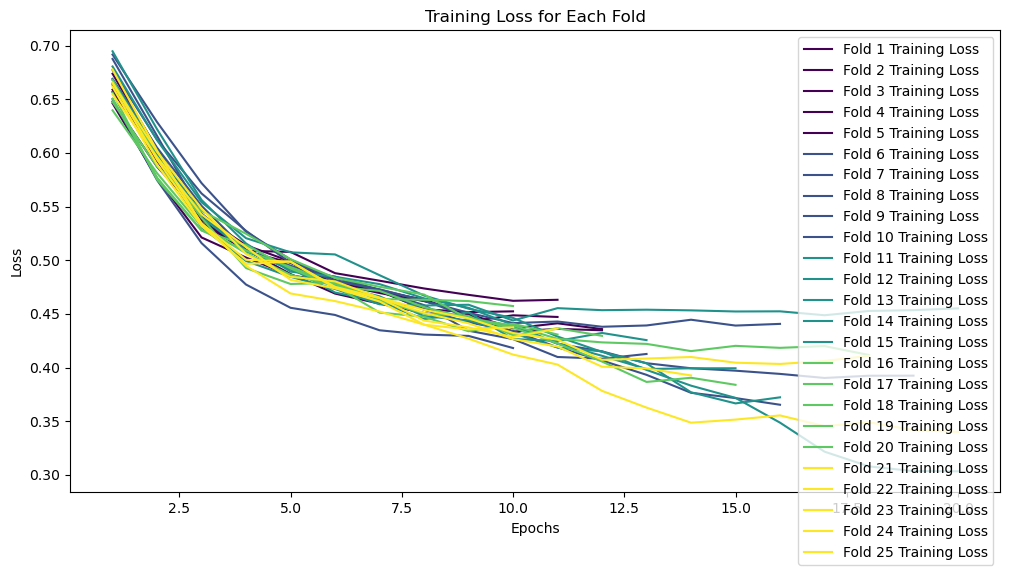

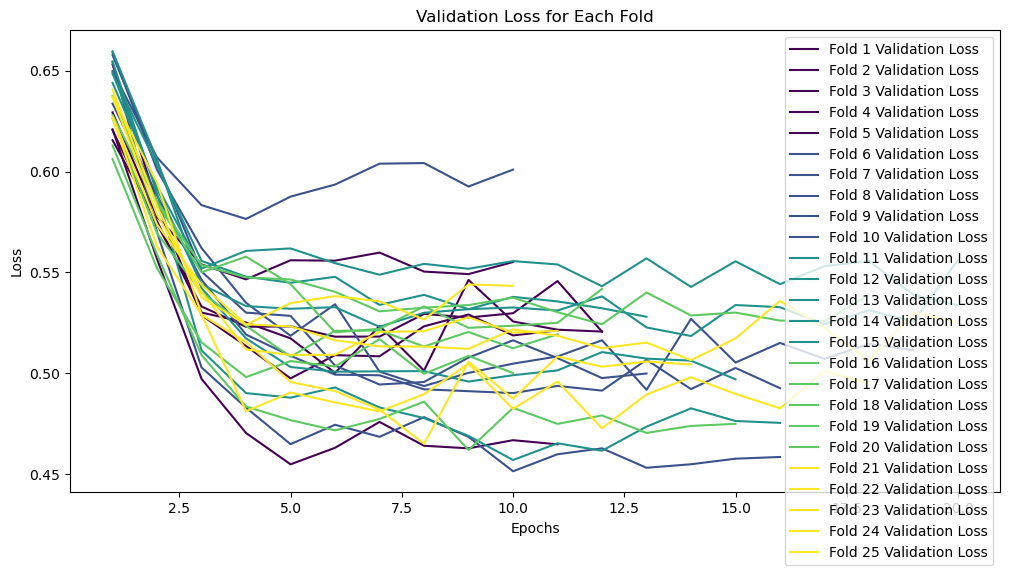

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_val_loss.svg")
plt.show()